# 4. 실습 - Convolutional Neural Network (CNN)

## 4.1 Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
%matplotlib inline
%config inlineBackend.figure_format='retina'
print(f"PyTorch version: [{torch.__version__}]")
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"device:[{device}]")

PyTorch version: [1.9.0+cu102]
device:[cuda:0]


<br>

## 4.2 Dataset

In [2]:
from torchvision import datasets, transforms

mnist_train = datasets.MNIST(root='./data/', train=True, transform=transforms.ToTensor(), download=True)
mnist_test = datasets.MNIST(root='./data/', train=False, transform=transforms.ToTensor(), download=True)
print(f"mnist_train:\n{mnist_train}\n")
print(f"mnist_test:\n{mnist_test}\n")
print('Done.')

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

mnist_train:
Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data/
    Split: Train
    StandardTransform
Transform: ToTensor()

mnist_test:
Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data/
    Split: Test
    StandardTransform
Transform: ToTensor()

Done.


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


<br>

## 4.3 Data Iterator

In [3]:
BATCH_SIZE = 256
train_iter = torch.utils.data.DataLoader(mnist_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=1)
test_iter = torch.utils.data.DataLoader(mnist_test, batch_size=BATCH_SIZE, shuffle=True, num_workers=1)
print('Done.')

Done.


<br>

## 4.4 Define Model

- 1x28x28 -> 14x14x32 -> 7x7x64

In [16]:
3//2

1

In [15]:
class ConvolutionalNeuralNetworkClass(nn.Module):
    """
        Convolutional Neural Network (CNN) Class
    """
    def __init__(self, name='cnn',
                 xdim=[1, 28, 28], ksize=3, cdims=[32, 64], hdims=[1024, 128], ydim=10,
                 USE_BATCHNORM=False):
        """
        cdims: channel dimensions
        """
        super(ConvolutionalNeuralNetworkClass, self).__init__()
        self.name = name
        self.xdim = xdim
        self.ksize = ksize
        self.cdims = cdims
        self.hdims = hdims
        self.ydim = ydim
        self.USE_BATCHNORM = USE_BATCHNORM        

        # Convolutional layers
        self.layers = []
        prev_cdim = self.xdim[0]
        for cdim in self.cdims: # for each hidden layer
            self.layers.append(
                nn.Conv2d(
                    # FILL IN HERE
                    in_channels=prev_cdim,
                    out_channels=cdim,
                    kernel_size=self.ksize,
                    stride=(1,1),
                    padding=self.ksize//2
                )
            ) # conv2d(1, 32) -> conv2d(32, 64)
            if self.USE_BATCHNORM:
                self.layers.append(nn.BatchNorm2d(cdim)) # batch-norm
            self.layers.append(nn.ReLU(True)) # activation
            self.layers.append(nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))) # max-pooling
            self.layers.append(nn.Dropout(p=0.5)) # dropout
            prev_cdim = cdim
        
        # Dense layers
        self.layers.append(nn.Flatten()) # 가장 마지막의 convolution layer 를 한 줄로 핌
        # 한 줄로 폈을 때 몇 개의 dimension 이 되는 지를 prev_hdim 이 가지고 있다.
        prev_hdim = prev_cdim*(self.xdim[1]//(2**len(self.cdims)))*(self.xdim[2]//(2**len(self.cdims)))
        for hdim in self.hdims:
            self.layers.append(nn.Linear(
                # FILL IN HERE
                prev_hdim, hdim, bias=True
            ))
            self.layers.append(nn.ReLU(True)) # activation
            prev_hdim = hdim
        
        # Final layer (without activation)
        self.layers.append(nn.Linear(prev_hdim, self.ydim, bias=True))

        # Concatenate all layers
        self.net = nn.Sequential()
        for l_idx, layer in enumerate(self.layers):
            layer_name = f"{type(layer).__name__.lower()}_{l_idx:02d}"
            self.net.add_module(layer_name, layer) # add_module() 의 가장 큰 장점은 layer의 이름을 지정할 수 있다는 것이다.
        self.init_param() # initialize parameters

    def init_param(self):
        for m in self.modules():
            print(m)
            print()
            if isinstance(m, nn.Conv2d): # init conv
                nn.init.kaiming_normal_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d): # init BN
                nn.init.constant_(m.weight, 1) # 초기값을 1로
                nn.init.constant_(m.bias, 0) # 초기값을 0으로
            elif isinstance(m, nn.Linear): # init dense
                nn.init.kaiming_normal_(m.weight)
                nn.init.zeros_(m.bias)
    
    def forward(self, x):
        return self.net(x)

C = ConvolutionalNeuralNetworkClass(
    name='cnn', xdim=[1, 28, 28], ksize=3, cdims=[32, 64], hdims=[32], ydim=10
).to(device)
loss = nn.CrossEntropyLoss()
optm = optim.Adam(C.parameters(), lr=1e-3)
print('Done.')

ConvolutionalNeuralNetworkClass(
  (net): Sequential(
    (conv2d_00): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu_01): ReLU(inplace=True)
    (maxpool2d_02): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (dropout_03): Dropout(p=0.5, inplace=False)
    (conv2d_04): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu_05): ReLU(inplace=True)
    (maxpool2d_06): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (dropout_07): Dropout(p=0.5, inplace=False)
    (flatten_08): Flatten(start_dim=1, end_dim=-1)
    (linear_09): Linear(in_features=3136, out_features=32, bias=True)
    (relu_10): ReLU(inplace=True)
    (linear_11): Linear(in_features=32, out_features=10, bias=True)
  )
)

Sequential(
  (conv2d_00): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_01): ReLU(inplace=True)
  (maxpool2d_02): MaxPool2d(kernel_size=(2, 2), strid

<br>

## 4.5 Check Parameters

In [6]:
np.set_printoptions(precision=3)
n_param = 0

for p_idx, (param_name, param) in enumerate(C.named_parameters()):
    if param.requires_grad:
        param_numpy = param.detach().cpu().numpy() # to numpy array
        n_param += len(param_numpy.reshape(-1))
        print(f"[{p_idx}] name:[{param_name}] shape:[{param_numpy.shape}].")
        print ("    val:%s"%(param_numpy.reshape(-1)[:5]))
        print()
print ("Total number of parameters:[%s]."%(format(n_param,',d')))

[0] name:[net.conv2d_00.weight] shape:[(32, 1, 3, 3)].
    val:[-0.521  0.021 -0.094 -0.018  0.49 ]

[1] name:[net.conv2d_00.bias] shape:[(32,)].
    val:[0. 0. 0. 0. 0.]

[2] name:[net.conv2d_04.weight] shape:[(64, 32, 3, 3)].
    val:[ 0.063  0.174 -0.225 -0.036 -0.031]

[3] name:[net.conv2d_04.bias] shape:[(64,)].
    val:[0. 0. 0. 0. 0.]

[4] name:[net.linear_09.weight] shape:[(32, 3136)].
    val:[ 0.003 -0.033  0.012 -0.04  -0.011]

[5] name:[net.linear_09.bias] shape:[(32,)].
    val:[0. 0. 0. 0. 0.]

[6] name:[net.linear_11.weight] shape:[(10, 32)].
    val:[ 0.046  0.068  0.217 -0.011  0.125]

[7] name:[net.linear_11.bias] shape:[(10,)].
    val:[0. 0. 0. 0. 0.]

Total number of parameters:[119,530].


<br>

## 4.6 Simple Forward Path of the CNN Model

In [9]:
np.set_printoptions(precision=3)
torch.set_printoptions(precision=3)

x_numpy = np.random.rand(2, 1, 28, 28)
x_torch = torch.from_numpy(x_numpy).float().to(device)
y_torch = C.forward(x_torch) # forward path
y_numpy = y_torch.detach().cpu().numpy() # torch tensor to numpy array

print ("x_torch:\n",x_torch,'\n')
print ("y_torch:\n",y_torch,'\n')
print ("\nx_numpy %s:\n"%(x_numpy.shape,),x_numpy,'\n')
print ("y_numpy %s:\n"%(y_numpy.shape,),y_numpy,'\n')

x_torch:
 tensor([[[[0.326, 0.072, 0.580,  ..., 0.999, 0.825, 0.541],
          [0.939, 0.761, 0.631,  ..., 0.253, 0.794, 0.733],
          [0.928, 0.630, 0.490,  ..., 0.808, 0.281, 0.189],
          ...,
          [0.361, 0.112, 0.332,  ..., 0.862, 0.981, 0.982],
          [0.884, 0.978, 0.927,  ..., 0.788, 0.036, 0.891],
          [0.728, 0.142, 0.854,  ..., 0.924, 0.079, 0.924]]],


        [[[0.651, 0.599, 0.430,  ..., 0.272, 0.345, 0.803],
          [0.757, 0.599, 0.490,  ..., 0.475, 0.482, 0.370],
          [0.586, 0.735, 0.417,  ..., 0.199, 0.587, 0.954],
          ...,
          [0.332, 0.219, 0.647,  ..., 0.144, 0.027, 0.216],
          [0.611, 0.793, 0.150,  ..., 0.078, 0.604, 0.006],
          [0.062, 0.960, 0.505,  ..., 0.218, 0.831, 0.505]]]], device='cuda:0') 

y_torch:
 tensor([[ 4.396, -5.822,  2.300,  6.935, -0.114,  0.396, -4.407,  0.339, -9.476,
          7.012],
        [ 0.763, -2.065,  4.798, -1.942,  6.917, -1.446, -2.284, -2.063, -5.627,
          5.104]], devic

<br>

## 4.7 Evaluation Function

In [10]:
def func_eval(model, data_iter, device):
    with torch.no_grad():
        n_total, n_correct = 0, 0
        model.eval() # evaluate (affects Dropout and BN)
        for batch_in, batch_out in data_iter:
            y_trgt = batch_out.to(device)
            model_pred = model(batch_in.view(-1, 1, 28, 28).to(device))
            _, y_pred = torch.max(model_pred.data, 1)
            n_correct += (y_pred == y_trgt).sum().item()
            n_total += batch_in.size(0)
        val_accr = (n_correct/n_total)
        model.train() # back to train mode
    return val_accr
print('Done.')

Done.


<br>

## 4.8 Initial Evaluation

In [11]:
C.init_param() # initialize parameters
train_accr = func_eval(C, train_iter, device)
test_accr = func_eval(C, test_iter, device)
print ("train_accr:[%.3f] test_accr:[%.3f]."%(train_accr,test_accr))

train_accr:[0.108] test_accr:[0.102].


<br>

## 4.9 Train

In [12]:
print ("Start training.")
C.init_param() # initialize parameters
C.train() # to train mode 
EPOCHS,print_every = 10,1

for epoch in range(EPOCHS):
    loss_val_sum = 0
    for batch_in, batch_out in train_iter:
        # Forward path
        y_pred = C.forward(batch_in.view(-1, 1, 28, 28).to(device))
        loss_out = loss(y_pred, batch_out.to(device))
        # Update
        # FILL IN HERE      # reset gradient 
        optm.zero_grad()
        # FILL IN HERE      # backpropagate
        loss_out.backward()
        # FILL IN HERE      # optimizer update        
        optm.step()
        loss_val_sum += loss_out
    loss_val_avg = loss_val_sum/len(train_iter)
    # Print
    if ((epoch % print_every) == 0) or (epoch == (EPOCHS-1)):
        train_accr = func_eval(C, train_iter, device)
        test_accr = func_eval(C, test_iter, device)
        print ("epoch:[%d] loss:[%.3f] train_accr:[%.3f] test_accr:[%.3f]."%
               (epoch,loss_val_avg,train_accr,test_accr))
print ("Done")        

Start training.
epoch:[0] loss:[0.722] train_accr:[0.954] test_accr:[0.955].
epoch:[1] loss:[0.190] train_accr:[0.975] test_accr:[0.974].
epoch:[2] loss:[0.127] train_accr:[0.980] test_accr:[0.979].
epoch:[3] loss:[0.105] train_accr:[0.983] test_accr:[0.983].
epoch:[4] loss:[0.090] train_accr:[0.987] test_accr:[0.987].
epoch:[5] loss:[0.080] train_accr:[0.989] test_accr:[0.988].
epoch:[6] loss:[0.075] train_accr:[0.989] test_accr:[0.989].
epoch:[7] loss:[0.067] train_accr:[0.991] test_accr:[0.989].
epoch:[8] loss:[0.066] train_accr:[0.991] test_accr:[0.989].
epoch:[9] loss:[0.061] train_accr:[0.992] test_accr:[0.990].
Done


<br>

## 4.10 Test

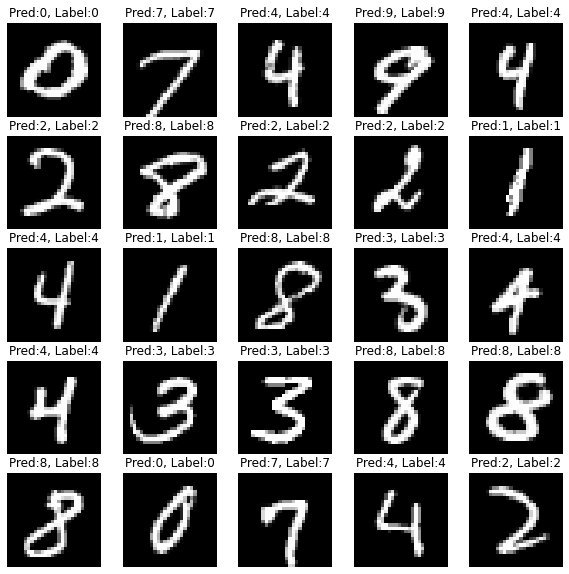

Done


In [13]:
n_sample = 25
sample_indices = np.random.choice(len(mnist_test.targets), n_sample, replace=False)
test_x = mnist_test.data[sample_indices]
test_y = mnist_test.targets[sample_indices]

with torch.no_grad():
    C.eval() # to evalution mode
    y_pred = C.forward(test_x.view(-1,1,28,28).type(torch.float).to(device)/255.)
y_pred = y_pred.argmax(axis=1)

plt.figure(figsize=(10,10))
for idx in range(n_sample):
    plt.subplot(5,5,idx+1)
    plt.imshow(test_x[idx], cmap='gray')
    plt.axis('off')
    plt.title("Pred:%d, Label:%d"%(y_pred[idx],test_y[idx]))
plt.show()    
print ("Done")    